# How to deal with Cell-Centered data arrays with IJ-Ordered Zones
You might expect that cell-centered data arrays have the same number of values as there are elements in the zone. This is not the case with structured data and will require special handling.

Read on for more info...

## We'll start by creating some example data

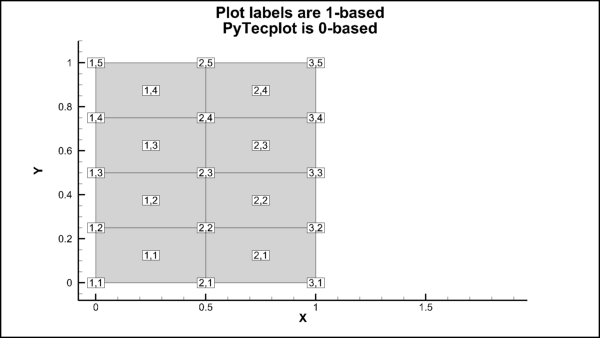

In [1]:
import numpy as np
import tecplot as tp
from tecplot.constant import *
tp.new_layout()
tp.macro.execute_command('''$!CreateRectangularZone 
  IMax = 3
  JMax = 5
  KMax = 1
  X1 = 0
  Y1 = 0
  Z1 = 0
  X2 = 1
  Y2 = 1
  Z2 = 1
  XVar = 1
  YVar = 2''')
plot = tp.active_frame().plot()
plot.show_mesh=True
plot.data_labels.show_node_labels=True
plot.data_labels.show_cell_labels=True
plot.axes.x_axis.min=-0.08
plot.axes.x_axis.max=1.2
plot.axes.y_axis.min=-0.08
plot.axes.y_axis.max=1.1
ds = tp.active_frame().dataset
zone = ds.zone(0)
tp.active_frame().add_text("Plot labels are 1-based\nPyTecplot is 0-based", position=(50,98), anchor=TextAnchor.HeadCenter, size=30)
tp.extension.ipython.show()

## Let's create a couple variables
Here we're creating a Cell Centered and a Nodal variable that we'll use for testing.  You can also see the variable values plotted in the image.

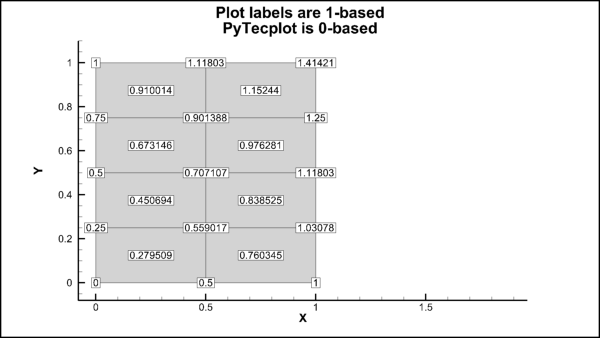

In [2]:
tp.data.operate.execute_equation("{CellCentered} = sqrt(X*X+Y*Y)", value_location=ValueLocation.CellCentered)
tp.data.operate.execute_equation("{Nodal} = sqrt(X*X+Y*Y)", value_location=ValueLocation.Nodal)
plot.data_labels.node_label_type = LabelType.VarValue
plot.data_labels.node_variable = ds.variable('Nodal')
plot.data_labels.cell_label_type = LabelType.VarValue
plot.data_labels.cell_variable = ds.variable('CellCentered')
tp.extension.ipython.show()

## The number of points and the number of nodal values is the same
This is a good thing

In [3]:
print("Points:",zone.num_points)
print("Nodal values:", len(zone.values("Nodal")))
print(zone.values("Nodal")[:])

Points: 15
Nodal values: 15
[0.         0.5        1.         0.25       0.559017   1.0307764
 0.5        0.70710677 1.118034   0.75       0.9013878  1.25
 1.         1.118034   1.4142135 ]


## Why do cell centered arrays have more values, than elements?
  * Because Tecplot 360 stores the values in a contiguous array that can be indexed by IJK values - the same as is done for nodal values. This introduces extraneous values in the flattened array
  * See section 3-2.2 in the User's Manual. https://tecplot.azureedge.net/products/360/current/help/topic.htm#t=Topics%2FOrdered_Data.htm&rhsearch=indexing&rhhlterm=indexing&rhsyns=%20

In [4]:
print("Elements:",zone.num_elements)
print("Cell values:",len(zone.values("CellCentered")))
print(zone.values("CellCentered")[:])

Elements: 8
Cell values: 12
[0.2795085  0.76034534 0.         0.4506939  0.8385255  0.
 0.6731456  0.9762812  0.         0.91001374 1.152443   0.        ]


## How are cell-centered data from ordered zones indexed?
They're indexed such that they use the same indexing as nodal data.  See section 3-2.2 in the User's Manual. https://tecplot.azureedge.net/products/360/current/help/topic.htm#t=Topics%2FOrdered_Data.htm&rhsearch=indexing&rhhlterm=indexing&rhsyns=%20

The index into the array can be defined as such: 
* CellIndex = i + (j)\*(imax) + k\*(imax-1)\*(jmax-1) (where IJK are 0-based)

See the cell_index() function coded in this script:
https://github.com/Tecplot/handyscripts/blob/master/jupyter_notebooks/ordered_cell_index.py

In [5]:
import ordered_cell_index as oci #see this script in GitHub

imax,jmax,kmax = zone.dimensions
k=0 # IJ case, so assume K=0
for j in range(jmax-1): ### JMAX-1 because data are not stored at JMAX
    for i in range(imax):
        cell_idx = oci.cell_index(zone,i,j,k)
        v = zone.values("CellCentered")[cell_idx]
        print("IJK", (i,j,k),"CellIndex", cell_idx, "Value", v)

IJK (0, 0, 0) CellIndex 0 Value 0.279508501291275
IJK (1, 0, 0) CellIndex 1 Value 0.7603453397750854
IJK (2, 0, 0) CellIndex 2 Value 0.0
IJK (0, 1, 0) CellIndex 3 Value 0.45069390535354614
IJK (1, 1, 0) CellIndex 4 Value 0.8385254740715027
IJK (2, 1, 0) CellIndex 5 Value 0.0
IJK (0, 2, 0) CellIndex 6 Value 0.673145592212677
IJK (1, 2, 0) CellIndex 7 Value 0.9762812256813049
IJK (2, 2, 0) CellIndex 8 Value 0.0
IJK (0, 3, 0) CellIndex 9 Value 0.910013735294342
IJK (1, 3, 0) CellIndex 10 Value 1.1524430513381958
IJK (2, 3, 0) CellIndex 11 Value 0.0


## How do I pull data out of PyTecplot that has the same dimension as the number of cells!
This can be done my reshaping the array and deleting the extraneous column of data

In [6]:
vals = zone.values("CellCentered")[:]
vals = vals.reshape(jmax-1,imax)
print(vals)
vals = np.delete(vals, imax-1, 1)
print(vals)
print("Array is now sized by num_elements:",len(vals.flatten()) == zone.num_elements)

[[0.2795085  0.76034534 0.        ]
 [0.4506939  0.8385255  0.        ]
 [0.6731456  0.9762812  0.        ]
 [0.91001374 1.152443   0.        ]]
[[0.2795085  0.76034534]
 [0.4506939  0.8385255 ]
 [0.6731456  0.9762812 ]
 [0.91001374 1.152443  ]]
Array is now sized by num_elements: True


## How do I stuff cell-centered data into an ordered zone?

### If you have a NumPy array dimensioned by JMax-1 x IMax-1
And you want to stuff that data into a cell-centered variable in an IJ-Ordered zone

For example:
[[1,2,3], [4,5,6]]

This can be done by padding the 2D array with an additional column of data.

In [7]:
# This is a JMax-1 by IMax-1 array (I is the fastest moving)
cc = np.random.rand(jmax-1,imax-1)
print(cc)
# The total number of values is equivalent to the number of elements
print(len(cc.flatten()) == zone.num_elements)

# Create a "padding" array to add an additional I-index of data
padding = np.zeros((jmax-1,1)) # np.empty() will be more efficient. np.zeros() is used for clarity.
print(padding)
data = np.hstack((cc,padding))
print(data)

# Now we should have an array that is JMax-1 x IMax
print(data.shape)
print(zone.dimensions)
print(len(data.flatten()) == len(zone.values("CellCentered")[:]))

# Now you can *finally* stuff the data into the cell centered variable
zone.values("CellCentered")[:] = data
print(zone.values("CellCentered")[:])

[[0.9743384  0.91133393]
 [0.71882462 0.57135466]
 [0.22317873 0.62811265]
 [0.53141346 0.32969354]]
True
[[0.]
 [0.]
 [0.]
 [0.]]
[[0.9743384  0.91133393 0.        ]
 [0.71882462 0.57135466 0.        ]
 [0.22317873 0.62811265 0.        ]
 [0.53141346 0.32969354 0.        ]]
(4, 3)
(3, 5, 1)
True
[0.9743384  0.9113339  0.         0.7188246  0.5713547  0.
 0.22317873 0.6281127  0.         0.53141344 0.32969353 0.        ]


### If you have a flat array dimensioned by the number of cell-centered values
And you want to stuff that data into a cell-centered variable in an IJ-Ordered zone.  This assumes that your array is ordered such that the I-dimension moves the fastest.

For example: If you have a 3,2 zone (IMax=3, JMax=2)
 * myarray = [1,2,3,4,5,6]
 * Values 1,2,3 are your I-values at J=0
 * Values 4,5,6 are your I-values at J=1
 
Simply reshape the flat array and then follow the steps above which do the padding

In [8]:
cc = np.random.rand(zone.num_elements)
print(cc)

#Reshape to Jmax-1 by Imax-1 and proceed with the padding array as above
cc = cc.reshape(jmax-1, imax-1)
print(cc)

# Create a "padding" array to add an additional I-index of data
padding = np.zeros((jmax-1,1)) # np.empty() will be more efficient. np.zeros() is used for clarity.
print(padding)
data = np.hstack((cc,padding))
print(data)

# Now we should have an array that is JMax-1 x IMax
print(data.shape)
print(zone.dimensions)
print("Array is the right size:", len(data.flatten()) == len(zone.values("CellCentered")[:]))

# Now you can *finally* stuff the data into the cell centered variable
zone.values("CellCentered")[:] = data
print(zone.values("CellCentered")[:])

[0.04661276 0.46002638 0.61948633 0.3511529  0.55884797 0.98772674
 0.8909544  0.11230192]
[[0.04661276 0.46002638]
 [0.61948633 0.3511529 ]
 [0.55884797 0.98772674]
 [0.8909544  0.11230192]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[0.04661276 0.46002638 0.        ]
 [0.61948633 0.3511529  0.        ]
 [0.55884797 0.98772674 0.        ]
 [0.8909544  0.11230192 0.        ]]
(4, 3)
(3, 5, 1)
Array is the right size: True
[0.04661276 0.46002638 0.         0.61948633 0.3511529  0.
 0.55884796 0.98772675 0.         0.8909544  0.11230192 0.        ]
